# 미니 경진대회 - 선박 도장 품질 분류

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
from collections import Counter
import matplotlib.font_manager as fm
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 시스템에 설치된 폰트 중 나눔고딕(NanumGothic) 찾기
# 만약 없다면, 다른 한글 폰트(예: Malgun Gothic)로 대체할 수 있습니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 일반적인 리눅스 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

ROOT = Path("/mnt/elice/dataset")

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

ROOT 디렉토리에는 선박 도장의 손상 정도를 파악하고 도장 품질의 검사 정확도 개선을 위한 선박 도장 상태별 이미지 데이터가 저장되어 있습니다. 데이터 이미지들은 아래와 같은 6개의 폴더에 나눠져 저장되어 있습니다.

* TS_도막 손상_도막떨어짐
* TS_도막 손상_스크래치
* TS_도장 불량_부풀음
* TS_도장 불량_이물질포함
* TS_양품_선수
* TS_양품_외판

이번 경진대회의 목표는 해당 이미지들을 활용하여 선박 도장의 손상 종류를 분류하는 것입니다. 각 폴더에 존재하는 이미지들의 라벨은 다음과 같습니다.

* TS_도막 손상_도막떨어짐 -> 도막떨어짐
* TS_도막 손상_스크래치 -> 스크래치
* TS_도장 불량_부풀음 -> 부풀음
* TS_도장 불량_이물질포함 -> 이물질포함
* TS_양품_선수 -> 양품
* TS_양품_외판 -> 양품

주의: 폴더의 경로를 찾을 수 없다는 오류 메시지가 발생하는 경우 한글 폴더 이름의 인코딩 문제일 수 있습니다. 아래 베이스라인 코드의 폴더명들을 활용하세요.

In [4]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품",
    "TS_양품_외판": "양품",
}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (128, 128)

# 이미지 데이터 탐색
## 이미지 크기 확인

이미지마다 크기가 다른 경우가 많음, 모델에 넣기전에 모든 이미지를 동일한 크기로 맞춰줘야 함.

In [5]:
image_sizes = [] # 이미지 크기를 저장할 빈 리스트

# 각 폴더를 돌며 이미지 파일 찾기
for folder in folder_to_label:
    folder_path = ROOT / folder
    # rglob("*")로 하위 폴더까지 모든 파일 탐색
    for p in folder_path.rglob("*"):
        # 파일 확장자가 이미지 확장자에 포함되는지 확인
        if p.suffix.lower() in IMG_EXTS:
            try:
                # PIL을 사용해 이미지 파일 열기
                with Image.open(p) as img:
                    # 이미지의 (가로, 세로) 크기만 가져와서 리스트에 추가
                    image_sizes.append(img.size)
            except IOError:
                # 파일이 손상되었거나 이미지가 아닐 경우 예외 처리
                print(f"이미지 파일을 여는 데 실패했습니다: {p}")
                continue

#---
### 📊 결과 분석

print(f"총 이미지 개수: {len(image_sizes)}")
print("="*30)

# 고유한 이미지 크기 종류
unique_sizes = sorted(list(set(image_sizes)))
print(f"고유한 이미지 크기 종류: {len(unique_sizes)}개")
print(f"모든 고유 크기: {unique_sizes}")
print("="*30)

# 가장 작은 크기와 가장 큰 크기
if image_sizes:
    print(f"가장 작은 이미지 크기: {min(image_sizes)}")
    print(f"가장 큰 이미지 크기: {max(image_sizes)}")


총 이미지 개수: 1200
고유한 이미지 크기 종류: 17개
모든 고유 크기: [(1272, 2828), (1284, 2851), (1320, 2828), (1349, 2851), (1592, 2828), (2121, 2828), (2138, 2138), (2138, 2851), (2331, 1311), (2542, 2121), (2828, 1272), (2828, 1320), (2828, 1592), (2828, 2121), (2851, 1284), (2851, 1349), (2851, 2138)]
가장 작은 이미지 크기: (1272, 2828)
가장 큰 이미지 크기: (2851, 2138)


이미지의 크기가 제각각.


총 1200장인데 17가지의 다른 크기가 있음.


전처리 과정에서 Resize 필수 


## 이미지 클래스별 분포 확인


이제 각 클래스에 이미지가 몇장 있는지, 즉, 균형 잡혀있는지 파악해야 함

In [6]:
y = [] # 라벨을 저장할 빈 리스트

# 각 폴더를 돌며 이미지 파일 찾기
for folder, label in folder_to_label.items():
    folder_path = ROOT / folder
    for p in folder_path.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            y.append(label)

# y 리스트에 있는 각 라벨의 개수를 센다
class_counts = Counter(y)

# 결과 출력하기
print(class_counts)

Counter({'양품': 400, '스크래치': 200, '부풀음': 200, '도막떨어짐': 200, '이물질포함': 200})


데이터가 지나치게 '양품'에 쏠려있다.
학습 시에 쏠려서 학습되고 다른 클래스를 제대로 인식하지 못할 수 있음.
이렇게 되면 실제로는 성능이 좋지 않은데, 양품을 맞히는 비율이 높아서 전체 정확도만 높게 나오는 문제가 발생할 수 있음

> 데이터 증강이나 오버샘플링 필요

## 이미지 샘플 시각화
이미지 화질, 밝기, 배경의 특징 확인해보기

잘못 라벨링된 이미지가 있을 수도 있으니 꼼꼼히 확인해볼 것.

### 파일경로 - 라벨매핑
Root 폴더를 탐색해서 각 라벨에 해당하는 이미지 파일들의 경로를 리스트로 정리하기

In [7]:
label_to_paths = {}
for folder, label in folder_to_label.items():
    folder_path = ROOT / folder
    # 파일 확장자가 이미지인 파일들의 경로만 리스트에 담기
    image_paths = [p for p in folder_path.rglob("*") if p.suffix.lower() in IMG_EXTS]
    # 라벨을 키(key), 이미지 경로 리스트를 값(value)으로 저장
    label_to_paths[label] = image_paths

### 이미지 샘플 시각화
label_to_paths 딕셔너리를 사용해 각 클래스별로 무작위 샘플을 뽑아 그래프로 보여줄 것임.

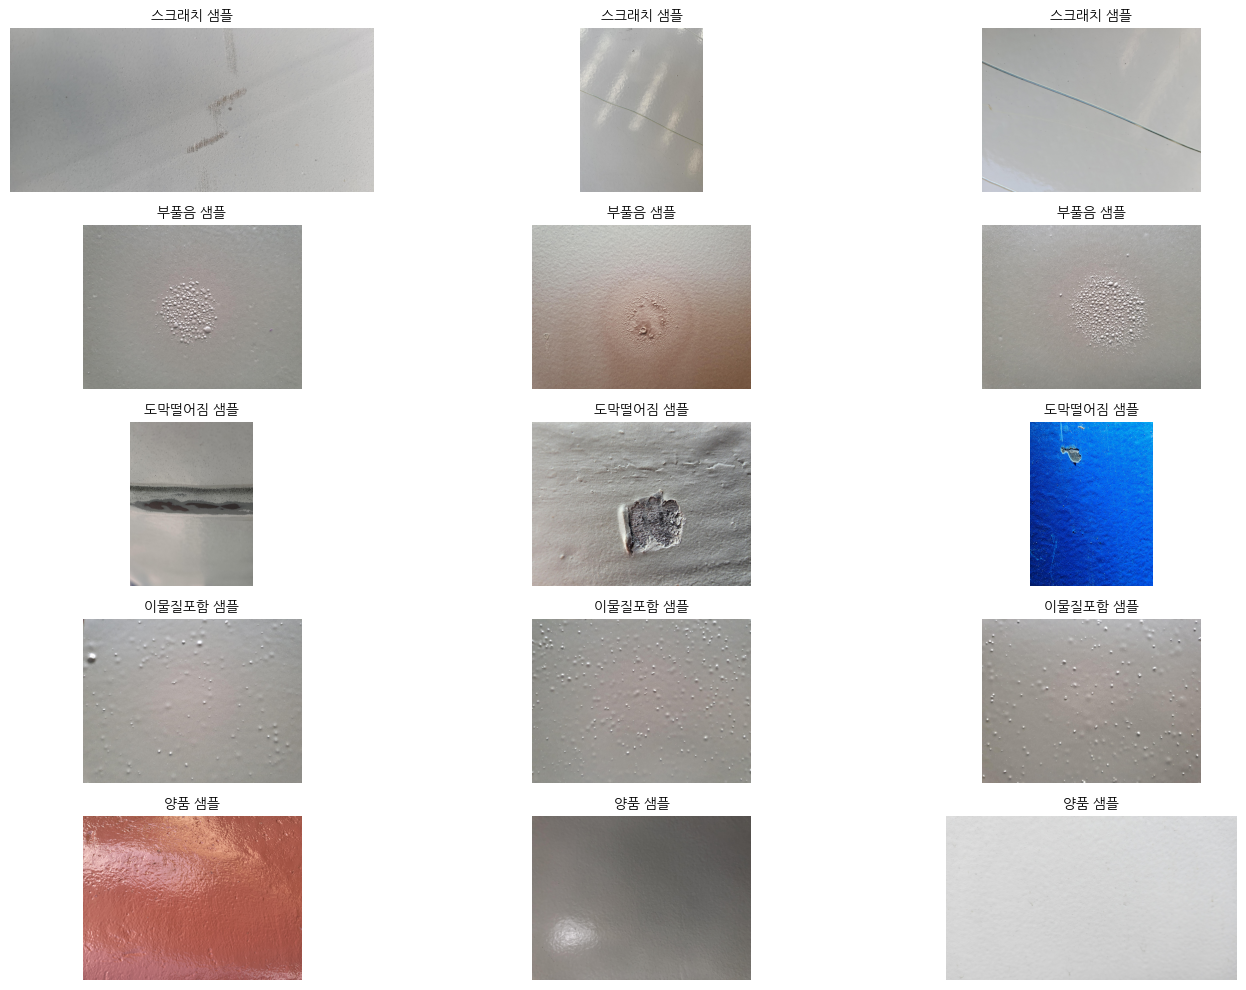

In [8]:
# 시각화 설정
plt.figure(figsize=(15, 10))  # 그래프 전체 크기 설정
num_samples = 3  # 각 클래스에서 보여줄 이미지 개수

# 각 라벨(클래스)별로 이미지 시각화
for i, (label, paths) in enumerate(label_to_paths.items()):
    # 현재 라벨에 해당하는 이미지 경로들에서 num_samples 개수만큼 무작위로 선택
    random_paths = random.sample(paths, min(num_samples, len(paths)))

    # 선택된 이미지를 하나씩 서브플롯(subplot)에 그리기
    for j, img_path in enumerate(random_paths):
        # subplot 위치 지정 (총 라벨 수, 각 라벨당 이미지 수, 현재 위치)
        ax = plt.subplot(len(label_to_paths), num_samples, i * num_samples + j + 1)
        
        # 이미지 열기 및 표시
        img = Image.open(img_path)
        plt.imshow(img)
        
        # 제목 설정 및 축 제거
        plt.title(f"{label} 샘플", fontsize=10)
        plt.axis("off")

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

1. 라벨링 오류: 잘못 분류된 이미지가 있는지 확인 필요.
:샘플로 통찰력 얻기, 그냥 전반적인 특성이랑 심각한 라벨링 오류가 있는지만 확인
> 학습 후 오류 분석 

2. 데이터 특성: 특정 패턴이 반복되는지 확인 필요
> 데이터 증강 기술 이용 필요: 회전 및 뒤집기, 색상 왜곡, 노이즈 추가

3. 배경이나 조명이 너무 다양해서 학습에 방해가 될 만한 요소는 없는지 확인 필요.
> 데이터 증강 기술 이용 필요: 밝기/대비 조절, 랜덤 크롭, 랜덤 이레이징 

--------------------------
'이물질 포함'이나 '부풀음' 클래스의 반복적인 패턴,
다양한 배경, 조명 문제가 보임
> 데이터 증강 기술 이용 필요! 

## 통합 전처리 파이프라인 구축 

:코드가 깔끔해질 수 있게 모든 전처리 과정을 하나로 묶자.

In [9]:
# ImageNet 데이터셋의 평균과 표준편차 (딥러닝에서 일반적으로 사용)
# 이 값은 모델의 학습 효율을 높여줍니다.
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# 1. 학습용 데이터 전처리 파이프라인 (Data Augmentation 포함)
train_transform = transforms.Compose([
    # 이미지 크기 통일 (다양한 크기 문제 해결)
    transforms.Resize(IMG_SIZE),
    
    # 조명/배경 문제, 과적합을 막기 위한 데이터 증강
    transforms.RandomHorizontalFlip(),  # 이미지를 무작위로 좌우 반전
    transforms.RandomVerticalFlip(),    # 이미지를 무작위로 상하 반전
    transforms.RandomRotation(30),       # 이미지를 -30도 ~ +30도 사이에서 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 밝기, 대비 등 무작위 조절
    
    # 이미지를 PyTorch 텐서로 변환 (0-255 -> 0-1)
    transforms.ToTensor(),
    
    # 픽셀 값 정규화
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 2. 검증/테스트용 데이터 전처리 파이프라인 (Data Augmentation 없음)
val_transform = transforms.Compose([
    # 이미지 크기 통일
    transforms.Resize(IMG_SIZE),
    
    # 이미지를 PyTorch 텐서로 변환
    transforms.ToTensor(),
    
    # 픽셀 값 정규화
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

## 전략적인 데이터 증강
: 데이터 불균형과 배경/조명 문제 해결을 위함.

In [10]:
# 1. 다수 클래스 ('양품')를 위한 전처리
# 증강을 최소화하여 데이터가 과하게 변형되는 것을 방지
majority_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 2. 소수 클래스를 위한 전처리 (더 공격적인 증강 적용)
minority_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.RandomVerticalFlip(),    # 상하 반전
    transforms.RandomRotation(30),      # 무작위 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 조명, 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])


# 2. X, y 리스트 초기화
X = [] # 이미지 데이터를 저장할 리스트
y = [] # 라벨을 저장할 리스트

# 3. 이미지를 로드하고 전처리하여 리스트에 추가
for folder, label in folder_to_label.items():
    d = ROOT / folder
    for p in d.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            try:
                img = Image.open(p).convert("RGB") # 이미지를 RGB로 로드
                
                # 라벨에 따라 다른 파이프라인 적용
                if label == "양품":
                    img_transformed = majority_transform(img)
                else:
                    img_transformed = minority_transform(img)
                
                # 변환된 이미지를 X 리스트에 추가
                X.append(img_transformed)
                # 라벨을 y 리스트에 추가
                y.append(label)
                
            except IOError:
                print(f"이미지를 여는 데 실패했습니다: {p}")
                continue

# X 리스트에 데이터가 PyTorch 텐서로 저장됩니다.
print(f"X 리스트에 저장된 이미지 데이터 개수: {len(X)}")
print(f"y 리스트에 저장된 라벨 개수: {len(y)}")
print("데이터 로딩 및 전처리 완료!")

X 리스트에 저장된 이미지 데이터 개수: 1200
y 리스트에 저장된 라벨 개수: 1200
데이터 로딩 및 전처리 완료!


# 데이터 분할

In [11]:
# 3. y 리스트의 문자열 라벨을 숫자로 변환
unique_labels = sorted(list(set(y)))
label_to_num = {label: i for i, label in enumerate(unique_labels)}
y_num = [label_to_num[label] for label in y]

# 이전에 만든 X(이미지 데이터)와 y(라벨) 리스트가 있다고 가정
# X는 리스트 형태이므로 배열로 변환
X = np.array(X)
y = np.array(y_num)

# 1. 학습(Train) & 테스트(Test) 세트로 먼저 분할
# test_size=0.2는 전체 데이터의 20%를 테스트 세트로 사용하겠다는 의미
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 학습 세트를 다시 학습(Train) & 검증(Validation) 세트로 분할
# test_size=0.25는 남은 학습 데이터(80%)의 25%이므로, 전체 데이터의 20%가 검증 세트가 됨
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 각 세트의 데이터 개수 확인
print("="*30)
print(f"학습 세트 크기: {X_train.shape[0]}개")
print(f"검증 세트 크기: {X_val.shape[0]}개")
print(f"테스트 세트 크기: {X_test.shape[0]}개")
print("="*30)

학습 세트 크기: 720개
검증 세트 크기: 240개
테스트 세트 크기: 240개


## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

전이 학습(Transfer Learning)의 이점: ResNet은 ImageNet이라는 거대한 데이터셋으로 이미 수백만 장의 이미지를 학습했어. 덕분에 이미지의 기본적인 특징(모서리, 질감, 색상 등)을 인식하는 방법을 이미 알고 있지. 너의 데이터셋에 맞게 모델의 마지막 부분만 미세 조정(Fine-tuning)하면, 처음부터 모델을 학습시키는 것보다 훨씬 적은 데이터로도 높은 성능을 빠르게 달성할 수 있어. 이는 시간과 컴퓨팅 자원을 절약하는 가장 효율적인 방법이야.

성능과 안정성: ResNet은 2015년 이미지넷 경진대회에서 1위를 차지했을 만큼 성능이 뛰어나. 무엇보다 ResNet의 핵심 기술인 잔차 블록(Residual Block)  덕분에 층을 깊게 쌓아도 경사 소실(Vanishing Gradient) 문제를 효과적으로 해결할 수 있지. 이는 모델이 깊어질수록 학습이 어려워지는 문제를 해결해 주므로, 안정적인 성능을 기대할 수 있어.

초보자에게 적합한 범용성: ResNet-18, ResNet-34, ResNet-50처럼 다양한 크기의 모델이 존재해서 데이터셋 규모나 컴퓨팅 환경에 맞춰 유연하게 선택할 수 있어. 또한, PyTorch와 같은 딥러닝 프레임워크에서 쉽게 불러와 사용할 수 있어서, 복잡한 모델 구조를 직접 구현하지 않아도 된다는 장점이 있지.

모델 파인 튜닝
1. ResNet(F1-score: 0.5338)
- param.requires_grad = False
- lr=0.001
2.ResNet(F1-score: 0.7377)
- param.requires_grad = True
- lr=0.0001

In [12]:
# 1. 사전 학습된 ResNet-18 모델 불러오기
# pretrained=True로 설정하여 ImageNet으로 미리 학습된 모델을 가져옵니다.
model = models.resnet18(pretrained=True)

# 2. 전이 학습(Transfer Learning)을 위해 앞부분 가중치 동결
# 모델의 앞쪽 레이어들은 이미지의 일반적인 특징(선, 모서리 등)을 인식하므로,
# 이 부분은 학습시키지 않고 그대로 사용합니다.
for param in model.parameters():
    param.requires_grad = True

# 3. 모델의 마지막 Fully Connected Layer 수정
# ResNet의 원래 출력은 1000개의 클래스(ImageNet)입니다.
# 우리의 데이터셋은 5개의 클래스이므로, 마지막 레이어를 5개로 변경해야 합니다.
num_ftrs = model.fc.in_features  # 마지막 레이어의 입력 피처 수 가져오기
model.fc = nn.Linear(num_ftrs, 5) # 새로운 출력 레이어를 5개로 설정 (클래스 개수)

# 4. 모델을 GPU로 옮기기 (GPU가 있을 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("모델 구축 완료!")
print(f"모델을 다음 장치로 옮겼습니다: {device}")

/home/elicer/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


모델 구축 완료!
모델을 다음 장치로 옮겼습니다: cuda


In [13]:
# 데이터를 텐서로 변환
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# 데이터셋을 TensorDataset으로 묶기
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor) 

# 데이터로더 생성 (데이터를 배치 단위로 불러오는 역할)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 1. 손실 함수와 옵티마이저 정의
# 손실 함수: 예측값과 실제값의 차이를 계산 (이미지 분류에는 CrossEntropyLoss가 적합)
criterion = nn.CrossEntropyLoss()
# 옵티마이저: 손실을 줄이기 위해 모델의 가중치를 업데이트 (Adam이 일반적으로 성능이 좋음)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 2. 모델 학습을 위한 반복문 (Training Loop)
num_epochs = 10  # 학습 횟수 (에포크 수)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train() # 모델을 학습 모드로 설정
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # 데이터를 GPU로 이동

        # 옵티마이저 초기화 (이전 기울기 제거)
        optimizer.zero_grad()

        # 순전파(Forward propagation)
        outputs = model(inputs)
        # 손실 계산
        loss = criterion(outputs, labels)

        # 역전파(Backward propagation)
        loss.backward()
        # 가중치 업데이트
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print('학습 완료!')

Epoch [1/10], Loss: 0.5476
Epoch [2/10], Loss: 0.0585
Epoch [3/10], Loss: 0.0220
Epoch [4/10], Loss: 0.0098
Epoch [5/10], Loss: 0.0111
Epoch [6/10], Loss: 0.0057
Epoch [7/10], Loss: 0.0037
Epoch [8/10], Loss: 0.0018
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0029
학습 완료!


# 모델 평가

In [14]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 모델을 평가 모드로 설정
model.eval()

# 손실 함수 정의 (학습 때와 동일)
criterion = nn.CrossEntropyLoss()

# 모델 평가 함수 정의
def evaluate_model(model, data_loader, device, criterion):
    # 총 예측 수, 맞힌 수, 손실을 저장
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    # ★ F1-Score 계산을 위해 모든 라벨과 예측값을 저장할 리스트 추가
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 예측 결과 확인
            _, predicted = torch.max(outputs.data, 1)

            # ★ 모든 라벨과 예측값을 리스트에 추가
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    # 루프가 끝난 후 최종 지표 계산
    avg_loss = running_loss / len(data_loader)
    accuracy = total_correct / total_samples

    # ★ 정밀도, 재현율, F1-Score 계산
    # average='macro'로 각 클래스의 점수를 동등하게 평균냅니다.
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='micro', zero_division=0)

    # ★ 모든 지표를 반환
    return avg_loss, accuracy, precision, recall, f1

# 1. 검증 세트 평가 (반환값 수정)
val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, device, criterion)
print(f"검증 손실(Validation Loss): {val_loss:.4f}")
print(f"검증 정확도(Validation Accuracy): {val_accuracy:.4f}")
print(f"검증 정밀도(Validation Precision): {val_precision:.4f}")
print(f"검증 재현율(Validation Recall): {val_recall:.4f}")
print(f"검증 F1-Score: {val_f1:.4f}")

# 2. 테스트 세트 평가 (반환값 수정)
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, device, criterion)
print(f"테스트 손실(Test Loss): {test_loss:.4f}")
print(f"테스트 정확도(Test Accuracy): {test_accuracy:.4f}")
print(f"테스트 정밀도(Test Precision): {test_precision:.4f}")
print(f"테스트 재현율(Test Recall): {test_recall:.4f}")
print(f"테스트 F1-Score: {test_f1:.4f}")

검증 손실(Validation Loss): 0.0910
검증 정확도(Validation Accuracy): 0.9667
검증 정밀도(Validation Precision): 0.9584
검증 재현율(Validation Recall): 0.9558
검증 F1-Score: 0.9667
테스트 손실(Test Loss): 0.0392
테스트 정확도(Test Accuracy): 0.9875
테스트 정밀도(Test Precision): 0.9838
테스트 재현율(Test Recall): 0.9850
테스트 F1-Score: 0.9875


## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **F1 Score**를 사용합니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에서 명시한 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

`submission.csv` 파일은 채점을 위한 코드입니다. index로는 테스트 데이터의 파일 이름들을, "label"열에는 해당 이미지 파일의 손상 종류를 저장해야 합니다. 아래와 같은 형태의 데이터프레임을 만든 뒤 `submission.csv` 파일로 저장해야 합니다.
* 아래 데이터프레임은 예시입니다.
   
|      | label |
| --------- | ----- |
| 00001.jpg | 양품    |
| 00002.jpg | 스크래치    |
| 00003.jpg | 양품    |
| 00004.jpg | 도막떨어짐    |
| 00005.jpg | 양품    |

In [15]:

# --- 이전에 정의한 변수들을 가져옵니다 ---
ROOT = Path("/mnt/elice/dataset/")  # 제출용 데이터셋의 상위 경로
SUBMIT_DIR = ROOT / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (128, 128)

# 1. 모델과 장치 불러오기
# 이전에 만든 model 변수와 device 변수를 그대로 사용합니다.
# model.to(device)와 model.eval() 상태여야 합니다.

# 2. 전처리 파이프라인 정의
# 제출용 데이터는 학습 시 사용한 검증/테스트 파이프라인과 동일해야 합니다.
submit_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. 라벨 맵핑을 위한 딕셔너리
# 이전에 만든 label_to_num 딕셔너리를 뒤집어서 사용합니다.
# 예: {0: '도막떨어짐', 1: '부풀음', ...}
num_to_label = {0: '도막떨어짐', 1: '부풀음', 2: '스크래치', 3: '양품', 4: '이물질포함'}
# 라벨 순서는 학습 당시의 unique_labels의 정렬 순서와 동일해야 합니다.

# 4. 예측 수행 및 결과 저장
filenames, labels = [], []
model.eval() # 모델을 평가 모드로 전환
with torch.no_grad(): # 경사 계산 비활성화
    for p in SUBMIT_DIR.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            # 1. 이미지 불러오기 및 전처리
            im = Image.open(p).convert("RGB")
            im_tensor = submit_transform(im).unsqueeze(0).to(device) # 모델 입력에 맞게 차원 추가

            # 2. 예측
            output = model(im_tensor)
            _, predicted = torch.max(output, 1) # ★ 이 부분이 predicted 변수를 만듭니다!
            
            # 3. 예측값(숫자)을 라벨(문자열)로 변환
            predicted_label = num_to_label[predicted.item()]

            filenames.append(p.name)
            labels.append(predicted_label)
            
#-------------------------------------
# 디버깅을 위해 이 부분을 추가
print("filenames 리스트의 첫 5개: ", filenames[:5])
print("labels 리스트의 첫 5개: ", labels[:5])
print("filenames 리스트의 총 개수: ", len(filenames))

# 5. 제출용 데이터프레임 생성 및 CSV 저장
df_submit = pd.DataFrame({
    "filename": filenames,
    "label": labels
})

# 데이터프레임의 파일 이름으로 정렬
df_submit = df_submit.sort_values(by="filename")

# CSV 파일로 저장. index=False로 설정해 인덱스 열을 포함하지 않음
df_submit.to_csv("./submission.csv", index=False)

print("submission.csv 파일이 성공적으로 저장되었습니다.")
df_submit.head()

filenames 리스트의 첫 5개:  ['00304.jpg', '00765.jpg', '00013.jpg', '00472.jpg', '00800.jpg']
labels 리스트의 첫 5개:  ['부풀음', '부풀음', '양품', '양품', '도막떨어짐']
filenames 리스트의 총 개수:  1000
submission.csv 파일이 성공적으로 저장되었습니다.


,filename,label
850,00001.jpg,도막떨어짐
238,00002.jpg,도막떨어짐
381,00003.jpg,스크래치
404,00004.jpg,스크래치
231,00005.jpg,양품


### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일